In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import json

import sys
import os

sys.path.append(os.path.abspath('../'))
from tool import *

data_root = '../../MyData/'

## Load data

In [2]:
item1_embedding = pd.read_csv(data_root+'merged_1197.csv')
item1_embedding = item1_embedding[['cik', 'tic', 'Year', 'item1_embeddings']]
print(len(item1_embedding))
print(item1_embedding.head())

other_embedding = pd.read_csv(data_root+'output_embeddings_2.csv')
other_embedding = other_embedding[['cik', 'SP_SHORT_DESC_embeddings', 'SP_LONG_DESC_embeddings', 'ORBIS_PROD_SERV_embeddings', 'ORBIS_OVERVIEW_embeddings']]
print(len(other_embedding))
print(other_embedding.head())

total_embedding = pd.merge(item1_embedding, other_embedding, on=['cik'])

# To reduce mem consumption
item1_embedding = ''
other_embedding = ''

print(len(total_embedding))
total_embedding.head()

1197
       cik   tic  Year                                   item1_embeddings
0   850460  WIRE  2021  [0.03955410048365593, -0.04159577935934067, -0...
1   352541   LNT  2021  [-0.0231856107711792, 0.001279839314520359, 0....
2  1704715   AMR  2021  [0.014074714854359627, 0.006938479840755463, 0...
3  1575515   SFM  2021  [-0.023708730936050415, 0.01762891560792923, 0...
4  1125376  ENSG  2021  [0.04463111609220505, 0.0018805989529937506, 0...
1197
       cik                           SP_SHORT_DESC_embeddings  \
0   850460  [0.01568225771188736, -0.07636360824108124, -0...   
1   352541  [-0.013836896046996117, -0.028995024040341377,...   
2  1704715  [0.0030535957776010036, 0.0008783274097368121,...   
3  1575515  [-0.025762900710105896, 0.0034106436651200056,...   
4  1125376  [0.04616139456629753, -0.0021259395871311426, ...   

                             SP_LONG_DESC_embeddings  \
0  [0.06089901179075241, -0.07059630751609802, -0...   
1  [-0.021961161866784096, 0.02030270546674

,cik,tic,Year,item1_embeddings,SP_SHORT_DESC_embeddings,SP_LONG_DESC_embeddings,ORBIS_PROD_SERV_embeddings,ORBIS_OVERVIEW_embeddings
0,850460,WIRE,2021,"[0.03955410048365593, -0.04159577935934067, -0...","[0.01568225771188736, -0.07636360824108124, -0...","[0.06089901179075241, -0.07059630751609802, -0...",NaN,NaN
1,352541,LNT,2021,"[-0.0231856107711792, 0.001279839314520359, 0....","[-0.013836896046996117, -0.028995024040341377,...","[-0.021961161866784096, 0.020302705466747284, ...","[-0.015400929376482964, 0.03232719004154205, -...","[-0.041709959506988525, -0.011898815631866455,..."
2,1704715,AMR,2021,"[0.014074714854359627, 0.006938479840755463, 0...","[0.0030535957776010036, 0.0008783274097368121,...","[-0.0017570963827893138, 0.006557094398885965,...","[-0.02030838653445244, -0.009386725723743439, ...","[-0.012340557761490345, -0.01428779773414135, ..."
3,1575515,SFM,2021,"[-0.023708730936050415, 0.01762891560792923, 0...","[-0.025762900710105896, 0.0034106436651200056,...","[-0.015190708450973034, 0.011541897431015968, ...","[-0.013177500106394291, 0.036401789635419846, ...","[-0.01883152313530445, 0.021741388365626335, 0..."
4,1125376,ENSG,2021,"[0.04463111609220505, 0.0018805989529937506, 0...","[0.04616139456629753, -0.0021259395871311426, ...","[0.05935207009315491, 0.0013673527864739299, 0...","[0.029405493289232254, 0.014010551385581493, 0...","[-0.006068837363272905, 0.010537531226873398, ..."


### Check dataset

In [3]:
nan_proportion = total_embedding.isna().mean()
print(f"The nan value proportion in each column:\n{nan_proportion}\n\n")

The nan value proportion in each column:
cik                           0.000000
tic                           0.000000
Year                          0.000000
item1_embeddings              0.000000
SP_SHORT_DESC_embeddings      0.041771
SP_LONG_DESC_embeddings       0.095238
ORBIS_PROD_SERV_embeddings    0.208020
ORBIS_OVERVIEW_embeddings     0.168755
dtype: float64




## Obtain tensors and prepare data

In [75]:
target_list = ['item1_embeddings', 'SP_LONG_DESC_embeddings', 'ORBIS_OVERVIEW_embeddings']
info_list = ['cik', 'tic', 'Year']

exp_df = convert_to_array(total_embedding, info_list, target_list, 1536, False)
print(type(exp_df))
print(exp_df.shape)


item1_np = np.vstack(exp_df['item1_embeddings'].values)
sp_long_np = np.vstack(exp_df['SP_LONG_DESC_embeddings'].values)
orbis_np = np.vstack(exp_df['ORBIS_OVERVIEW_embeddings'].values)

d:\NGNE\clustering_project\5 Synthetic Data Generation\tool.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df[target] = data_df[target].apply(


<class 'pandas.core.frame.DataFrame'>
(1197, 6)


In [76]:
sp_long_np = sp_long_np[~np.all(np.isnan(sp_long_np), axis=1)]
orbis_np = orbis_np[~np.all(np.isnan(orbis_np), axis=1)]
X = np.vstack([item1_np, sp_long_np, orbis_np])
print(X.shape)

(3275, 1536)


In [77]:
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset, random_split

# Convert NumPy array to PyTorch tensor
X_tensor = torch.tensor(X, dtype=torch.float32)

# Custom Dataset class for VAE (no labels)
class VAE_Dataset(Dataset):
    def __init__(self, features):
        self.features = features

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Return only the input data (no labels)
        return self.features[idx]

# Create the full dataset
dataset = VAE_Dataset(X_tensor)

# Split dataset into train and test (80% train, 20% test)
train_size = int(0.85 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for train and test
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check the shape of a batch
for batch in train_loader:
    print(batch.shape)  # (32, 10) assuming batch size of 32
    break  # Just print the first batch


torch.Size([64, 1536])


## Autoencoder definition

In [7]:
class AE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, drop_rate):
        super(AE, self).__init__()
        
        # Encoder network (module)
        self.encoder_net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LayerNorm(1024),  # Layer Norm to stabilize training
            nn.ReLU(),
            nn.Dropout(drop_rate),

            nn.Linear(1024, hidden_dim),
            nn.LayerNorm(hidden_dim),  # Layer Norm to stabilize training
            nn.ReLU(),
            nn.Dropout(drop_rate),
            
            nn.Linear(hidden_dim, latent_dim),  # Outputs mean and log-variance
            # nn.Sigmoid()
        )

        # Decoder network (with Layer Normalization)
        self.decoder_net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),  # Layer Norm to stabilize training
            nn.ReLU(),
            nn.Dropout(drop_rate),

            nn.Linear(hidden_dim, 1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            nn.Dropout(drop_rate),

            nn.Linear(1024, input_dim),
            nn.Tanh()
        )
    
    def encode(self, x):
        h = self.encoder_net(x)
        return h

    
    def decode(self, z):
        x_reconstructed = self.decoder_net(z)
        return x_reconstructed

    def forward(self, x):
        z = self.encode(x)
        x_reconstructed = self.decode(z)
        return x_reconstructed

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
# Hyperparameters
data_dim = 1536
hidden_dim = 512
latent_dim = 256
drop_rate = 0.2

# Recreate the model class and initialize it
ae = AE(data_dim, hidden_dim, latent_dim, drop_rate).to(device)  # Replace with your actual model class

# Load the state dictionary
ae.load_state_dict(torch.load("./saved_model/basic_ae.pth"))

def obtain_latent(target):
    ae.eval()
    with torch.no_grad():
        target = target.unsqueeze(1).to(device)
        latent = ae.encode(target)
    return latent

## Conditional Generative Adersarial Network definition

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, noise_dim, output_dim):
        super(Generator, self).__init__()
        self.scale = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.shift = nn.Parameter(torch.zeros(1))  # Initialized to 0

        self.model = nn.Sequential(
            nn.Linear(latent_dim + noise_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),

            # nn.Linear(256, 512),
            # nn.BatchNorm1d(512),
            # nn.LeakyReLU(0.2),

            # nn.Linear(32, 64),
            # nn.BatchNorm1d(64),
            # nn.LeakyReLU(0.2),

            nn.Linear(256, output_dim),
            nn.Tanh()
        )

    def forward(self, latent, noise):
        x = torch.cat((latent, noise), dim=1)
        res = self.model(x)
        return res*self.scale + self.shift
        



class Discriminator(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # spectral_norm(nn.Linear(input_dim + latent_dim, 512)),
            # nn.LeakyReLU(0.2),
            # spectral_norm(nn.Linear(512, 1))

            nn.Linear(input_dim + latent_dim, 128),
            nn.LeakyReLU(0.2),

            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, input, latent):
        x = torch.cat((input, latent), dim=1)
        return self.model(x)
        

## CGAN training testing

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
# Hyperparameters
latent_dim = 256  # Size of the noise vector
data_dim = 1536  # Size of your data vectors
noise_dim = 16
batch_size = 64  # Batch size
num_epochs = 100  # Number of epochs


# Initialize generator and discriminator
G = Generator(latent_dim=latent_dim, noise_dim=noise_dim, output_dim=data_dim)
D = Discriminator(input_dim=data_dim, latent_dim=latent_dim)

for param in G.parameters():
    if param.dim() > 1:
        torch.nn.init.xavier_uniform_(param)
for param in D.parameters():
    if param.dim() > 1:
        torch.nn.init.xavier_uniform_(param)

# Loss function and optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

G.to(device)
D.to(device)
adversarial_loss.to(device)


for epoch in range(num_epochs):
    total_D_loss = 0
    total_G_loss = 0
    for i, real_vectors in enumerate(train_loader):
        
        real_vectors = real_vectors.to(device)
        latent = obtain_latent(real_vectors).squeeze(1)
        noise = torch.randn(real_vectors.size(0), noise_dim).to(device)
        real_label = torch.ones(real_vectors.size(0), 1).to(device)
        fake_label = torch.zeros(real_vectors.size(0), 1).to(device)
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        with torch.no_grad():
            gen_vectors = G(latent, noise)
        fake_pred = D(gen_vectors, latent)
        fake_loss = adversarial_loss(fake_pred, fake_label)
        real_pred = D(real_vectors, latent)
        real_loss = adversarial_loss(real_pred, real_label)

        D_loss = (real_loss + fake_loss)
        D_loss.backward()
        optimizer_D.step()
        total_D_loss += D_loss.item()


        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        gen_vectors = G(latent, noise)
        fake_pred = D(gen_vectors, latent)
        l2_norm = sum(param.pow(2.0).sum() for param in G.parameters()) * 0.005
        G_loss = adversarial_loss(fake_pred, real_label) + l2_norm
        G_loss.backward()
        optimizer_G.step()
        total_G_loss += G_loss.item()




    print(f"[Epoch {epoch+1}/{num_epochs}] "
          f"[D loss: {total_D_loss:.4f}] "
          f"[G loss: {total_G_loss:.4f}] "
        #   f"[regularization: {(l2_norm):.4f}] "
          f"[pred real ratio: {(real_pred.sum() / len(real_pred)):.4f}]")

[Epoch 1/100] [D loss: 81.8305] [G loss: 235.9081] [pred real ratio: 0.4451]
[Epoch 2/100] [D loss: 77.3567] [G loss: 225.4659] [pred real ratio: 0.4321]
[Epoch 3/100] [D loss: 78.0671] [G loss: 213.7840] [pred real ratio: 0.4073]
[Epoch 4/100] [D loss: 73.8038] [G loss: 204.2403] [pred real ratio: 0.4460]
[Epoch 5/100] [D loss: 69.0300] [G loss: 193.6951] [pred real ratio: 0.4698]
[Epoch 6/100] [D loss: 68.5458] [G loss: 185.8550] [pred real ratio: 0.4476]
[Epoch 7/100] [D loss: 66.9184] [G loss: 177.4523] [pred real ratio: 0.4761]
[Epoch 8/100] [D loss: 67.2986] [G loss: 170.9345] [pred real ratio: 0.4555]
[Epoch 9/100] [D loss: 64.8338] [G loss: 164.8881] [pred real ratio: 0.4915]
[Epoch 10/100] [D loss: 61.0257] [G loss: 156.4368] [pred real ratio: 0.4883]
[Epoch 11/100] [D loss: 63.2194] [G loss: 149.2152] [pred real ratio: 0.4897]
[Epoch 12/100] [D loss: 62.2402] [G loss: 143.1444] [pred real ratio: 0.4912]
[Epoch 13/100] [D loss: 62.5313] [G loss: 137.7566] [pred real ratio: 0.4

In [187]:
G.scale

Parameter containing:
tensor(0.8040, device='cuda:0', requires_grad=True)

torch.Size([8, 1536])
torch.Size([8, 1536])
tensor([[ 0.0165, -0.0027,  0.0186,  ...,  0.0207,  0.0307,  0.0282],
        [ 0.0209, -0.0014,  0.0174,  ...,  0.0211,  0.0235,  0.0217],
        [ 0.0228,  0.0004,  0.0138,  ...,  0.0233,  0.0242,  0.0290],
        ...,
        [ 0.0404, -0.0082,  0.0233,  ...,  0.0329,  0.0467,  0.0386],
        [ 0.0111, -0.0017,  0.0190,  ...,  0.0167,  0.0309,  0.0279],
        [ 0.0200, -0.0038,  0.0125,  ...,  0.0215,  0.0205,  0.0244]])


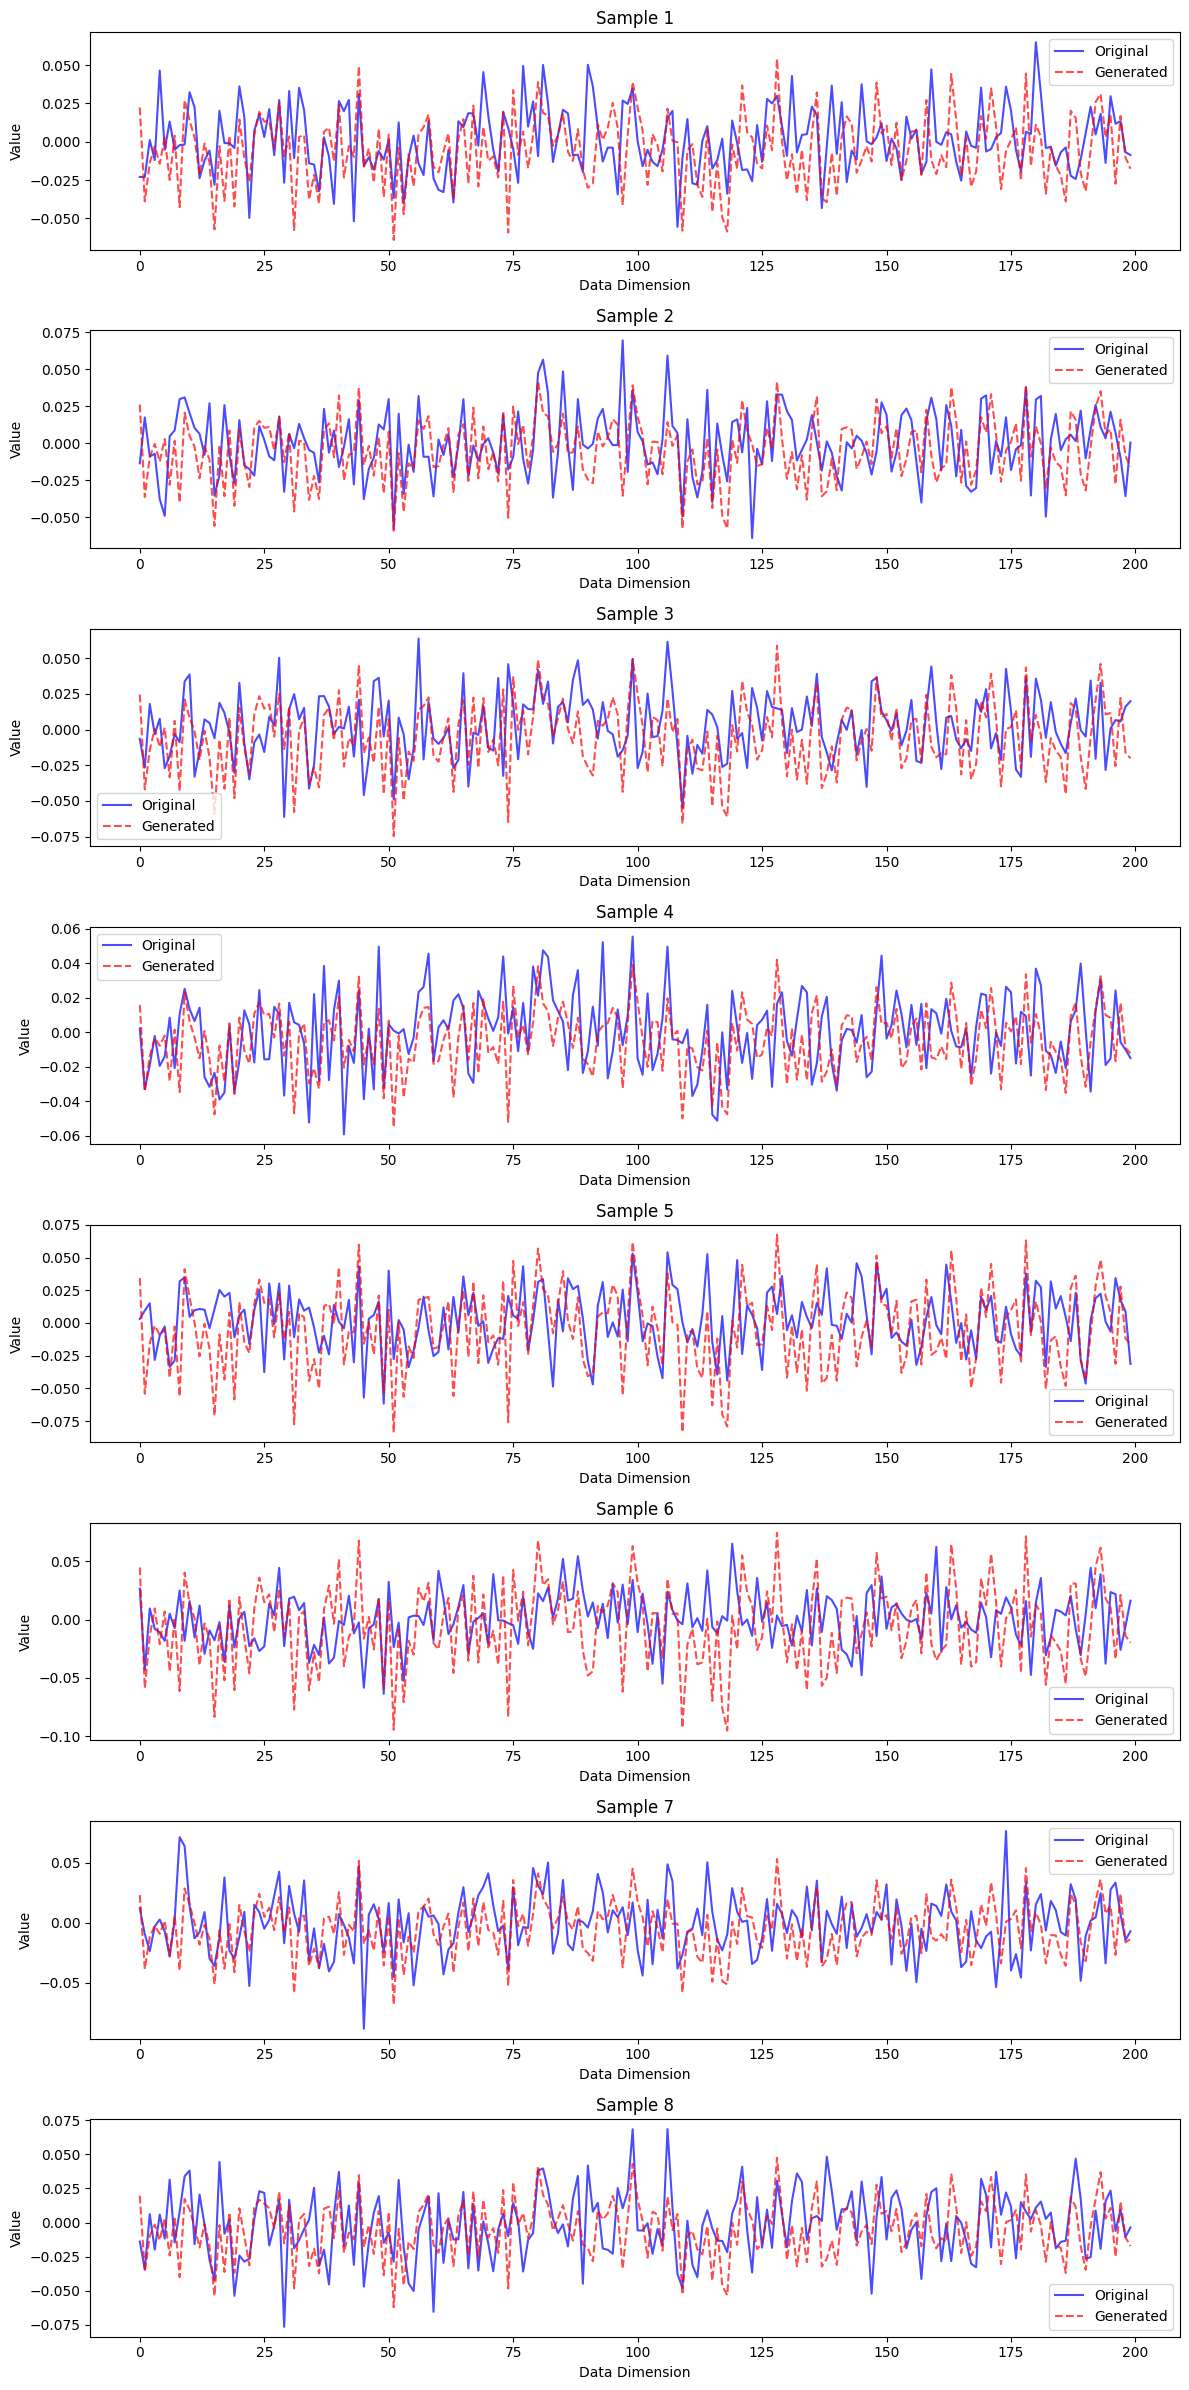

In [188]:
# Assuming x is a batch of input data (1D, not images)
x = next(iter(train_loader))  # Get a batch of data
x = x[8:16]  # Take the first 8 samples in the batch (shape: [8, input_dim])

latent = obtain_latent(x.to(device)).squeeze(1)
with torch.no_grad():
    noise = torch.randn(x.size(0), noise_dim).to(device)
    generated_samples = G(latent, noise)
generated_samples = generated_samples.squeeze(1).cpu()

print(x.shape)
print(generated_samples.shape)

print(generated_samples)

# Plot the original and generated samples in separate subplots
fig, axes = plt.subplots(8, 1, figsize=(12, 24))  # 8 rows, 1 column
    
for i in range(8):
    axes[i].plot(x[i][900:1100], label="Original", linestyle='-', color='b', alpha=0.7)
    axes[i].plot(generated_samples[i][900:1100], label="Generated", linestyle='--', color='r', alpha=0.7)
    axes[i].set_title(f"Sample {i+1}")
    axes[i].set_xlabel("Data Dimension")
    axes[i].set_ylabel("Value")
    axes[i].legend()
    
plt.tight_layout()
plt.show()

